In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from networkx.drawing.nx_pydot import graphviz_layout


rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'Liberation Serif']

# Load Data

In [17]:
## load data

output_folder = 'experiment'

# move_df is having one row per move
move_df = pd.read_csv(os.path.join('../data/exp_processed/moves_w_alignment.csv'))

strategy_df = pd.read_csv(os.path.join('../data/exp_strategies_coded/coded_strategies.csv'))

# we use only the second strategy
strategy_df = strategy_df[strategy_df['written_strategy_idx'] == 1]

move_df = move_df.merge(strategy_df[['session_id', 'loss_strategy']], on='session_id', how='left')

# select only demonstration trials
move_df = move_df[move_df['trial_type'] == 'demonstration']


## aggregate data

# columns to group by
index_columns = ['session_id', 'session_name', 'replication_idx', 'within_generation_idx', 'ai_player', 'generation', 'condition']

# aggregate all moves of a trial
trial_df = move_df.groupby([*index_columns, 'trial_id']).agg({'reward': 'sum', 'human_machine_match': 'mean', 'loss_strategy': 'max', 'advisor': 'first'}).reset_index()

# aggregate all trials of a player
player_df = trial_df.groupby(index_columns).agg({'reward': 'mean', 'human_machine_match': 'mean', 'loss_strategy': 'max', 'advisor': 'first'}).reset_index()


## post-process data

player_df = player_df.rename(columns={'human_machine_match': 'machine_alignment', 'reward': 'player_score'})

# add a unique id for each population
player_df['population_id'] = player_df['replication_idx'].astype(str) + ' ' + player_df['condition']

# machines do not have a strategy, we fill it with -1
player_df['loss_strategy_int'] = player_df['loss_strategy'].fillna(-1).astype(int)

# make sure that the within_generation_idx for each population starts at 0
player_df['within_generation_idx'] = player_df.groupby(['replication_idx', 'condition', 'generation'])['within_generation_idx'].rank(method='first', ascending=True) - 1

player_df = player_df.sort_values(['replication_idx', 'condition', 'within_generation_idx'])


# classify populations

# populations that have at least one player with a score above 2000 in generation 4
generation_above_threshold = (player_df.groupby(['generation', 'population_id'])['player_score'].max() > 2000).reset_index().set_index(['generation', 'player_score'])
last_gen_above_threshold = generation_above_threshold.loc[(4,True),'population_id'].tolist()
is_last_gen_above_threshold = player_df['population_id'].isin(last_gen_above_threshold)

# populations that have a machine
is_with_machine = player_df['condition'] == 'w_ai'


player_df['classification'] = 'none'
player_df.loc[is_last_gen_above_threshold & is_with_machine, 'classification'] = 'persistent'
player_df.loc[~is_last_gen_above_threshold & is_with_machine, 'classification'] = 'temporary'
player_df.loc[is_last_gen_above_threshold & ~is_with_machine, 'classification'] = 'discovered'
player_df.loc[~is_last_gen_above_threshold & ~is_with_machine, 'classification'] = 'naive'

/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_58010/1642609850.py:51: PerformanceWarning: indexing past lexsort depth may impact performance.
  last_gen_above_threshold = generation_above_threshold.loc[(4,True),'population_id'].tolist()


## Common Code for the Visualization

In [18]:
## labels for plots

metric_name = {
    'player_score': 'performance',
    'machine_alignment': 'alignment',
    'loss_strategy': 'strategy',
    'loss_strategy_int': 'strategy'
}
binary_metrics = ['loss_strategy_int']
continues_metrics = ['player_score', 'machine_alignment']
all_metrics = continues_metrics + binary_metrics

In [19]:
color_map = {
}

for metric in continues_metrics:

    min_player_score = player_df[metric].min()
    max_player_score = player_df[metric].max()

    # Base color map
    cmap = plt.cm.get_cmap('viridis')

    cnorm = plt.Normalize(vmin=min_player_score, vmax=max_player_score)
    cpick = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    color_map[metric] = cpick


color_map['loss_strategy_int'] = {
    -1: '#BDBDBD',
    0: '#440154',
    1: '#fde725'
}

/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_58010/3278198565.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


In [20]:
def draw_network_legend(ax, add_colors=True, node_size=200):
    G = nx.DiGraph()
    for i in range(6 if add_colors else 4):
        G.add_node(i, label=i)
    G.add_edge(2, 3)
    node_positions = {
        0: (0, 3.3),
        1: (0, 2.7),
        2: (0, 2.0),
        3: (0, 1.0),
        4: (0, 4.5),
        5: (0, 4.0)
    }
    node_shapes = {
        0: 'o',
        1: 's',
        2: 'o',
        3: 'o',
        4: 'o',
        5: 'o'
    }
    node_colors = {
        0: 'black',
        1: 'black',
        2: 'black',
        3: 'black',
        4: color_map['loss_strategy_int'][1],
        5: color_map['loss_strategy_int'][0]
    }
    node_labels = {
        0: 'Human',
        1: 'AI',
        2: 'Teacher',
        3: 'Student',
        4: 'Loss Strategy',
        5: 'No Loss Strategy'
    }


    # Draw the network
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)


    for pos in range(6 if add_colors else 4):
        ax.text(node_positions[pos][0] + 0.3, node_positions[pos][1], node_labels[pos], ha='left', va='center', fontsize=14)
    ax.axis('off')

def draw_population(df, ax, metric, node_size=200, explode=False):
    # Create a directed graph
    G = nx.DiGraph()
    node_colors = {}
    node_positions = {}
    node_labels = {}
    node_shapes = {}
    ax.axis('off')

    n_gen = df['generation'].max() + 1

    for idx, player in df.iterrows():
        session_id = str(player['session_id'])
        # Add nodes
        G.add_node(session_id, label=player['session_name'])
        # Assign color
        cpick = color_map[metric]
        if metric in binary_metrics:
            node_colors[session_id] = cpick[player[metric]]
        else:
            node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player[metric]))
        x_shift = 0
        y_shift = n_gen

        node_positions[session_id] = ((player['within_generation_idx'] + x_shift), (y_shift - player['generation']))
        # Add labels
        node_labels[session_id] = player['session_name']
        # Assign shapes
        node_shapes[session_id] = 's' if player['ai_player'] else 'o'

        # Add edges
        if not pd.isna(player['advisor']):
            advisor_id = str(player['advisor'])
            G.add_edge(advisor_id, str(player['session_id']))

    if explode:
        node_positions = graphviz_layout(G, prog="dot")

    # Draw the different shapes of nodes separately
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)


# Create Supplementary Figures

/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_58010/377823261.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_58010/377823261.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


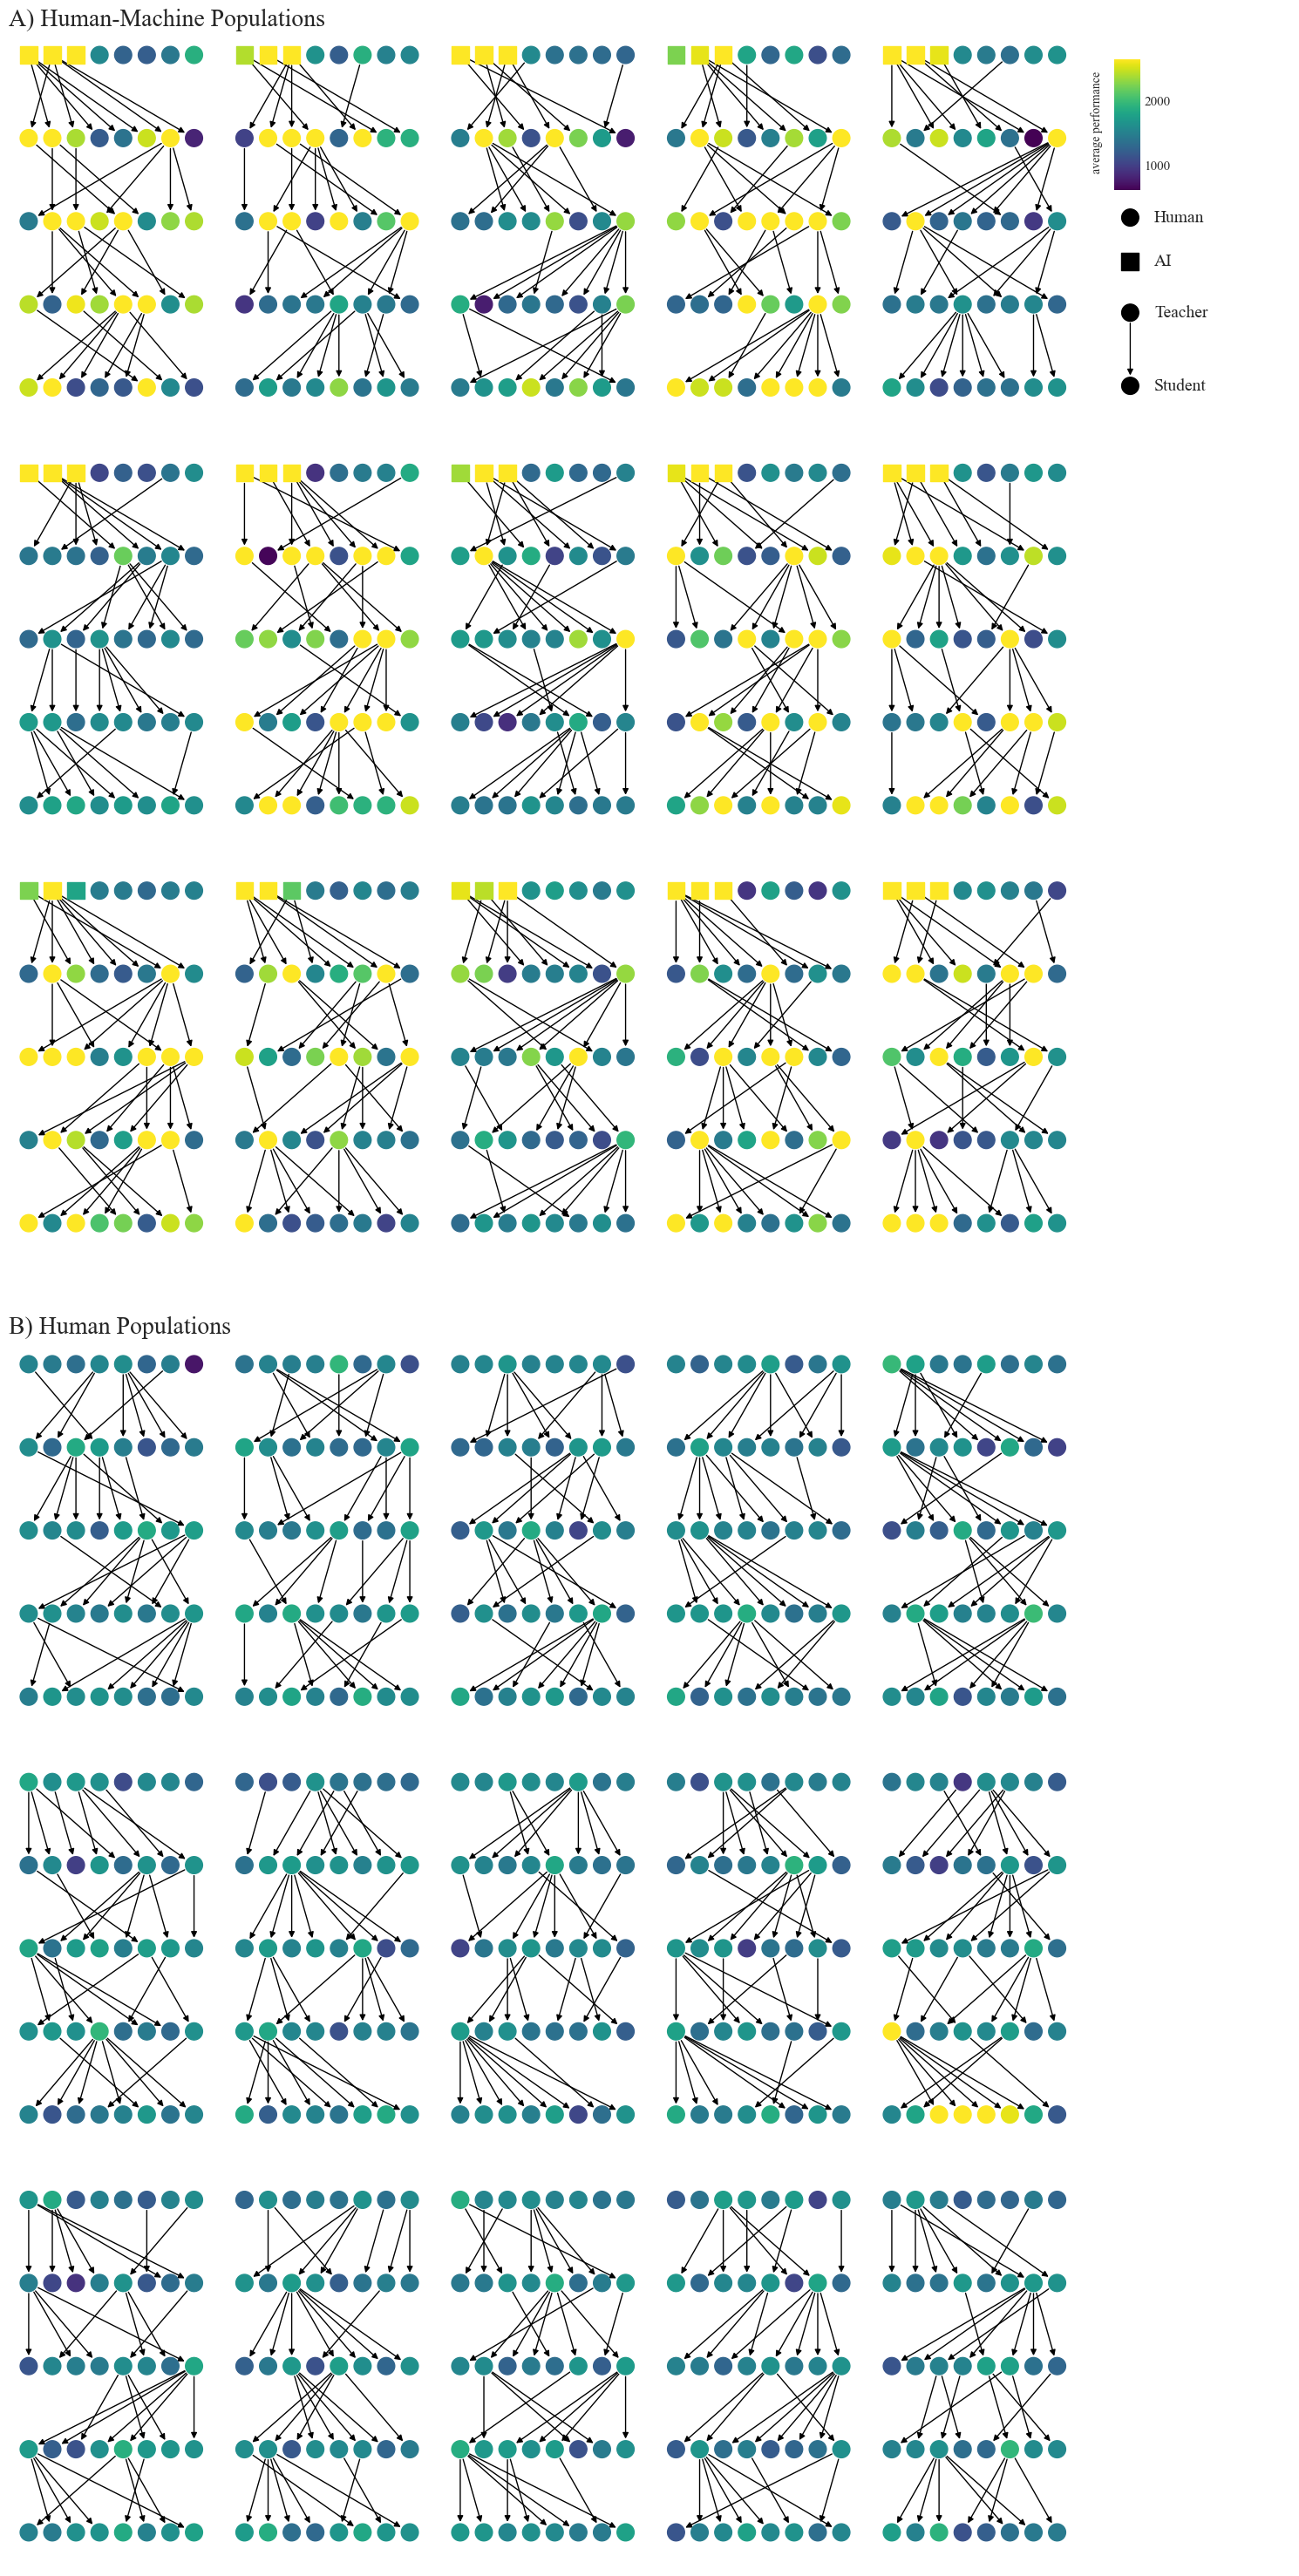

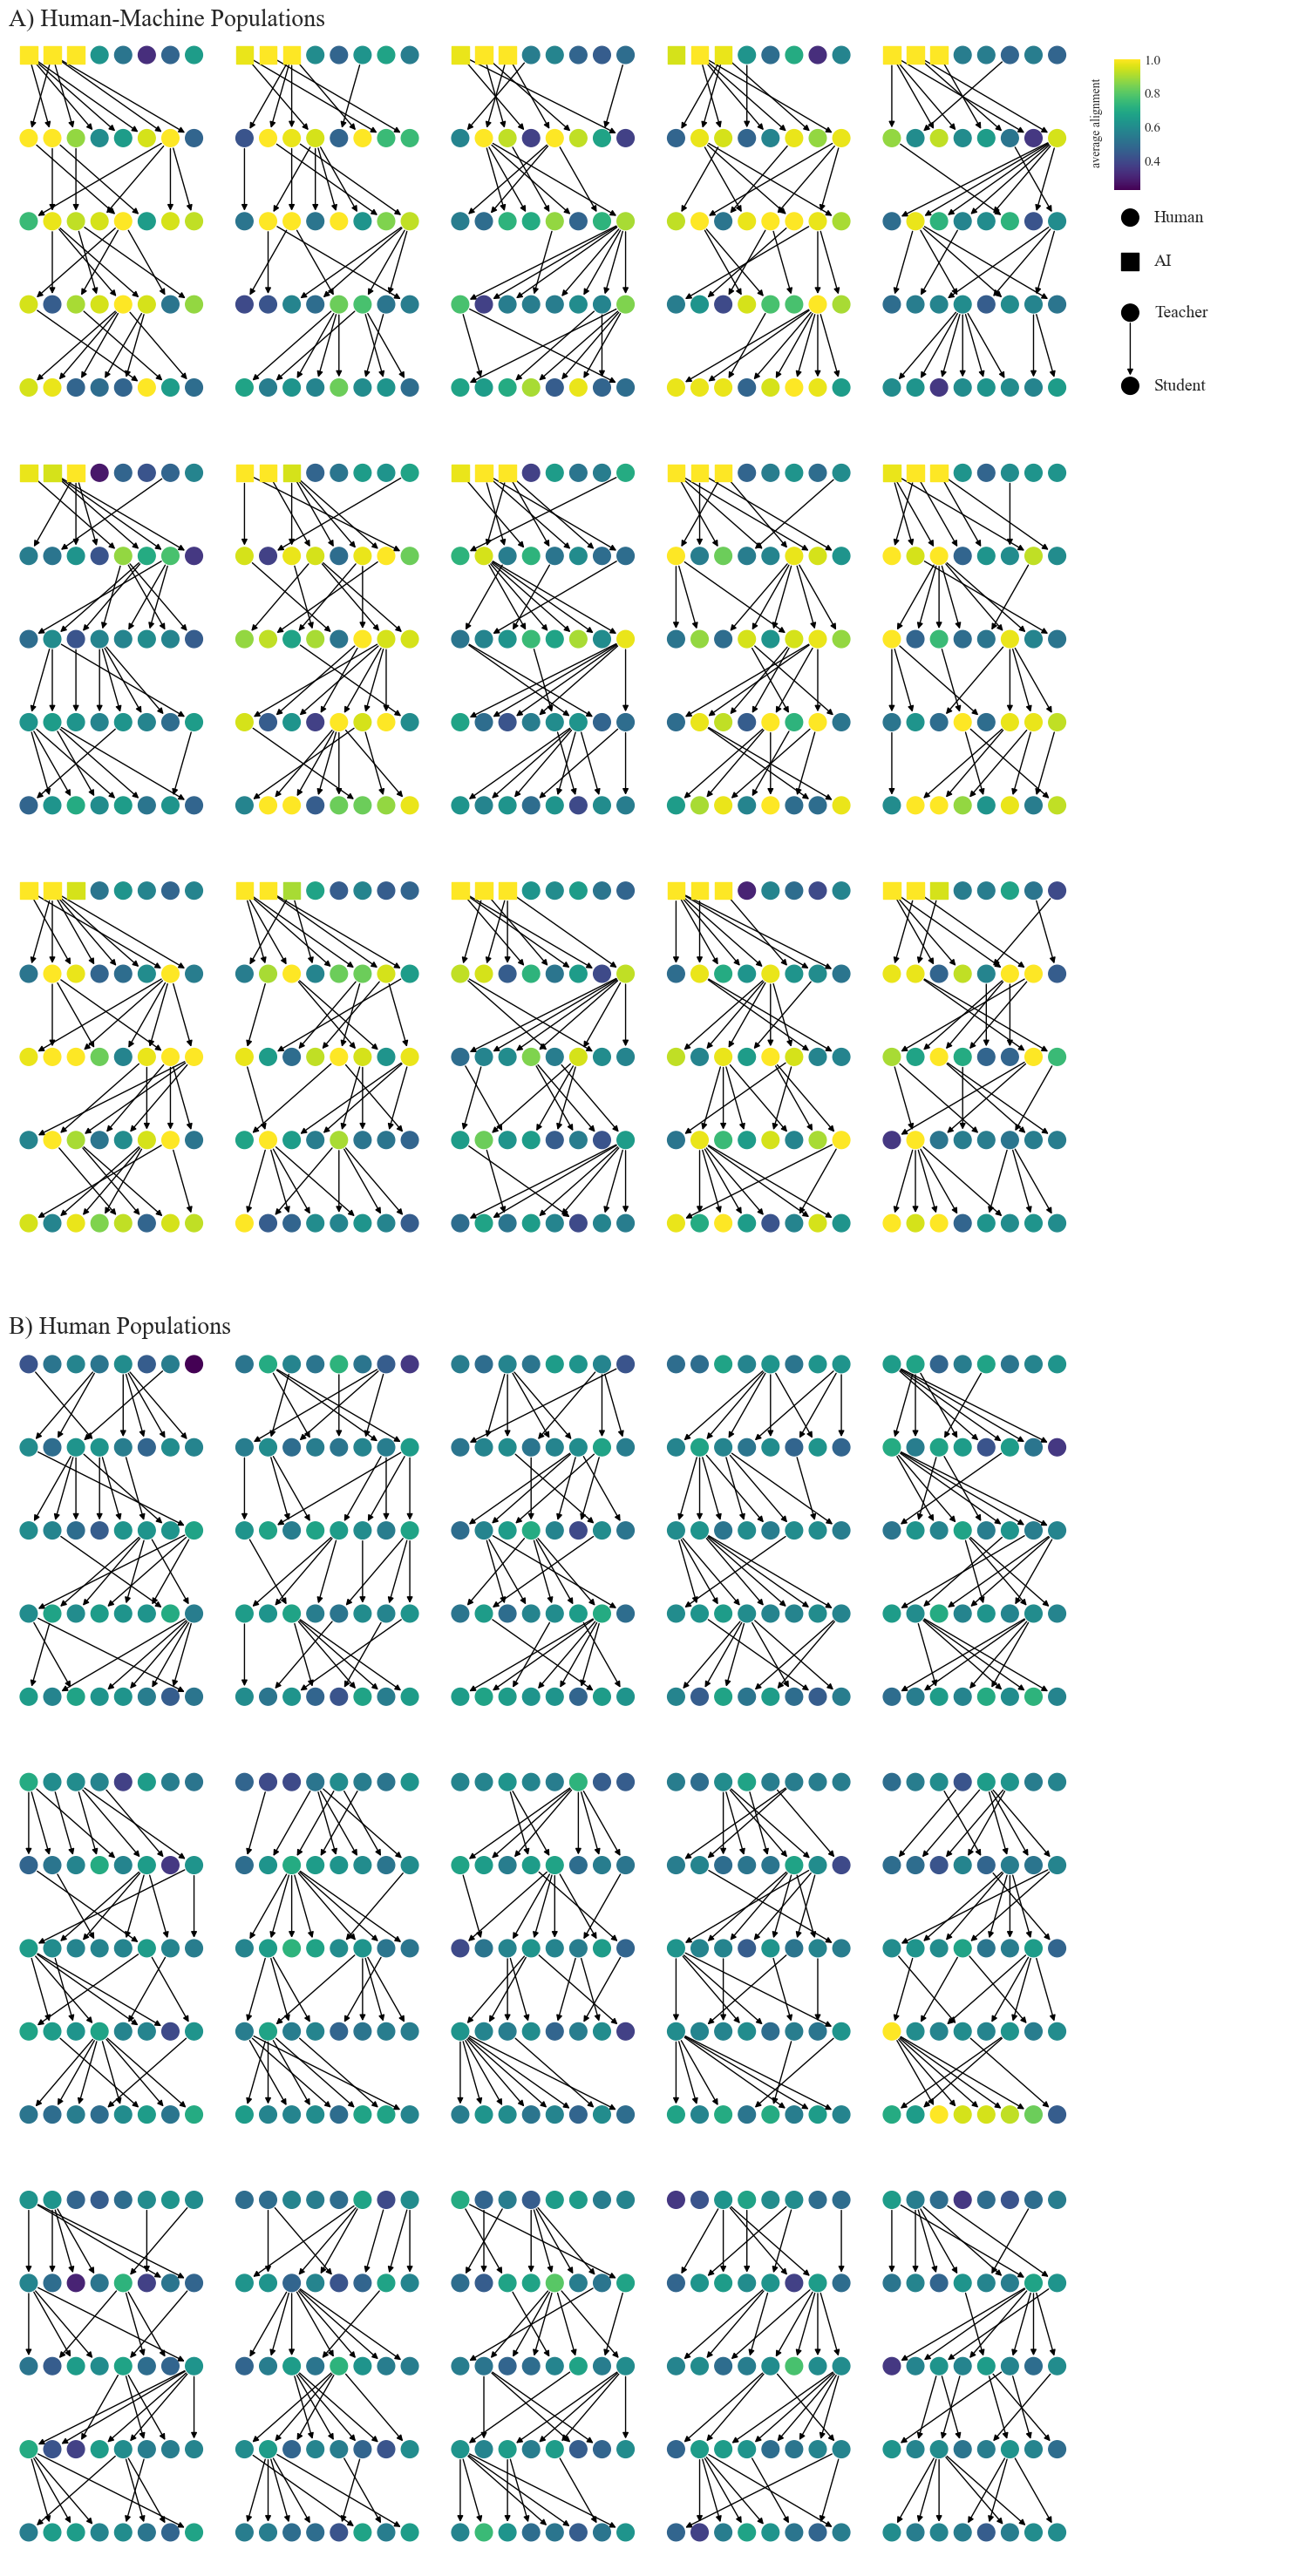

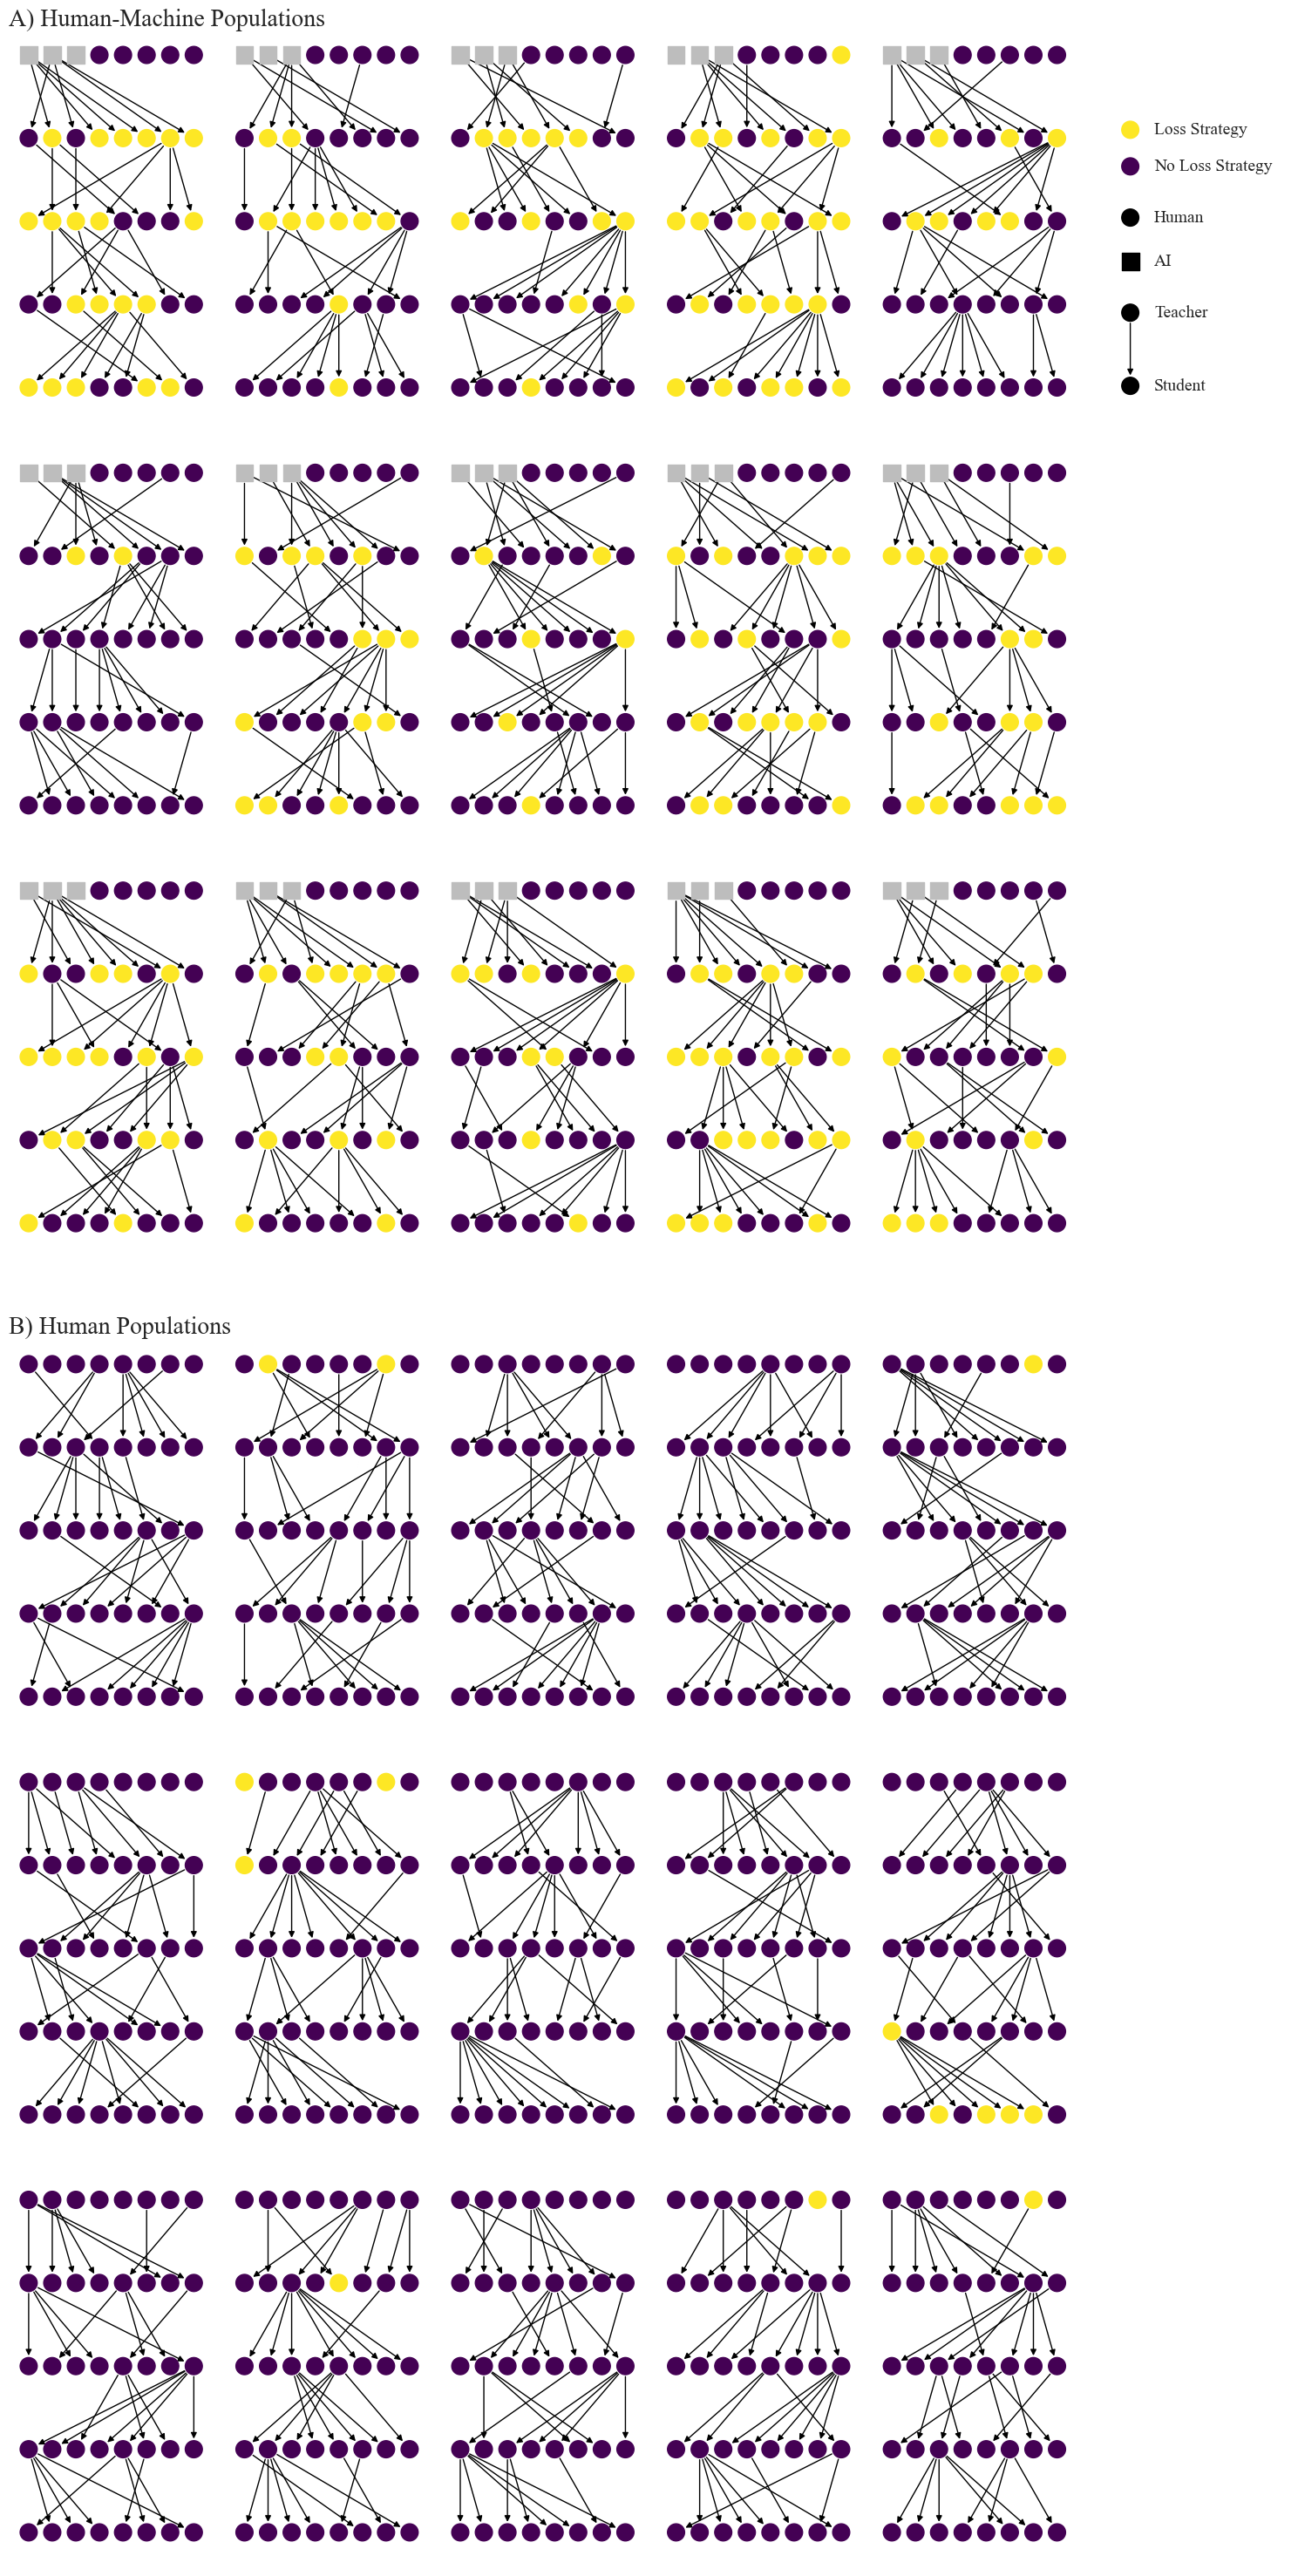

In [21]:
node_size = 200

# plot all populations
df = player_df

n_reps = df['replication_idx'].max() + 1
rows = 6
cols = n_reps // (rows // 2)

for metric in all_metrics:
    ## Set up the figure

    fig = plt.figure(figsize=(cols*3, rows*5))
    gs = gridspec.GridSpec(rows + 1, cols + 1, height_ratios=[1, 1, 1, 0.1, 1, 1, 1])


    ## Draw populations

    for (rep_idx, con), rep_df in df.groupby(['replication_idx', 'condition']):
        row = rep_idx // cols + (4 if con == 'wo_ai' else 0)
        col = rep_idx % cols
        ax = plt.subplot(gs[row, col])

        draw_population(rep_df, ax, metric, node_size=200)


    # Add titles
    fig.text(0.01, 0.98, 'A) Human-Machine Populations', ha='left', va='center', fontsize=20)
    fig.text(0.01, 0.48, 'B) Human Populations', ha='left', va='center', fontsize=20)


    ## Add legend
    ax = plt.subplot(gs[0, 5])
    if metric == 'loss_strategy_int':
        draw_network_legend(ax, add_colors=True)
    else:
        draw_network_legend(ax, add_colors=False)
        ax.text(-0.50, 4.6, f'average {metric_name[metric]}', ha='left', va='center', fontsize=10, rotation=90)
        cbar_ax = fig.add_axes([0.855, 0.915, 0.02, 0.05])
        cb = plt.colorbar(color_map[metric], cax=cbar_ax)
        cb.outline.set_edgecolor('none')
        cb.ax.tick_params(length=0)
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(0.5, 6)

    ## Save plot
    file_name = os.path.join('plots',output_folder,f'network_{metric}.png')
    pdf_filename = os.path.join('plots',output_folder,f'network_{metric}.pdf')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99)
    plt.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

## Visualize four prototypical populations

/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_58010/3350902838.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


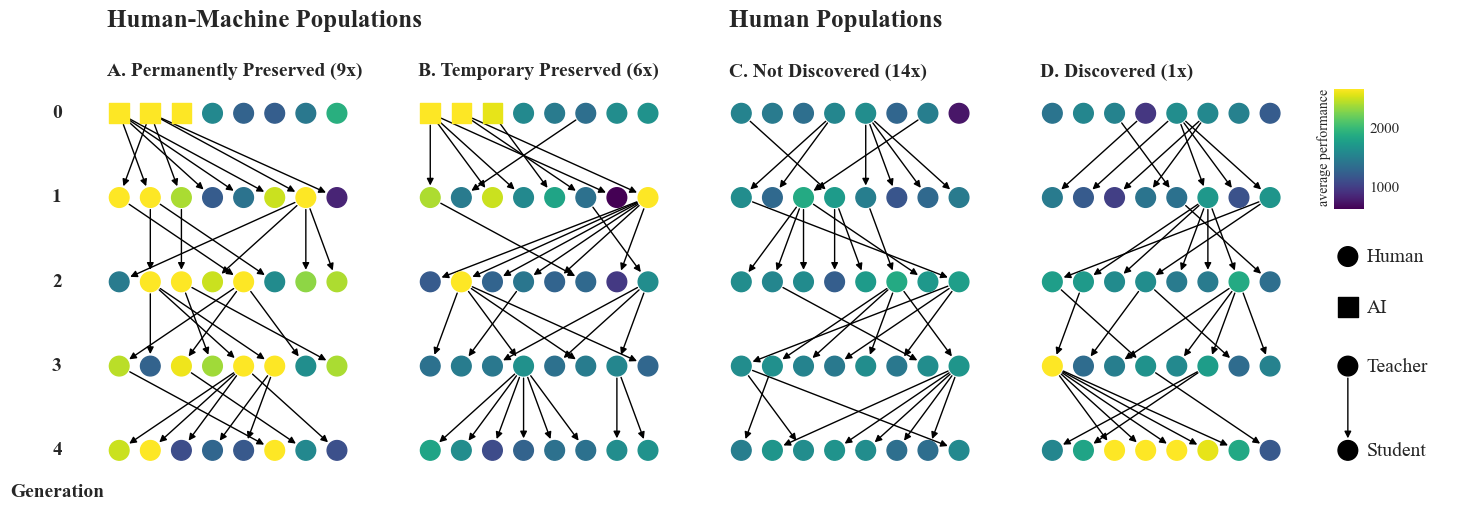

In [22]:
classes = [
    'persistent', 'temporary', 'naive', 'discovered'
]

header = {
    'persistent': 'Human-Machine Populations',
    'naive': 'Human Populations'
}


subheader = {
    'persistent': 'A. Permanently Preserved (9x)',
    'temporary': 'B. Temporary Preserved (6x)',
    'naive': 'C. Not Discovered (14x)',
    'discovered': 'D. Discovered (1x)'
}




# select the first population id for each class
class_population_id = player_df.groupby('classification')['population_id'].first().to_dict()


for metric in all_metrics:

    n_gen = player_df['generation'].max() + 1


    cols = 4
    rows = 1

    # Create figure and define GridSpec
    fig = plt.figure(figsize=((cols+1)*3, rows*5))
    gs = gridspec.GridSpec(1, 6, width_ratios=[0.1, 1, 1, 1, 1, 0.5])  # Adjust the grid layout


    for i, c in enumerate(classes):

        df = player_df[player_df['population_id'] == class_population_id[c]]

        row = 0
        col = i + 1

        ax = plt.subplot(gs[row, col])
        ax.axis('off')

        draw_population(df, ax, metric, node_size=200)

        ax.set_ylim(0.5, 6)
        ax.set_xlim(-1.5, 8.5)

        if c in header:
            ax.text(-0.4, 6.1, header[c], ha='left', va='center', fontsize=18, fontweight='bold')

        ax.text(-0.4, 5.5, subheader[c], ha='left', va='center', fontsize=14, fontweight='bold')


    ## Add legend

    ax = plt.subplot(gs[0, 5])
    if metric == 'loss_strategy_int':
        draw_network_legend(ax, add_colors=True)
    else:
        draw_network_legend(ax, add_colors=False)
        ax.text(-0.50, 4.6, f'average {metric_name[metric]}', ha='left', va='center', fontsize=10, rotation=90)
        cbar_ax = fig.add_axes([0.898, 0.62, 0.02, 0.24])
        cb = plt.colorbar(color_map[metric], cax=cbar_ax)
        cb.outline.set_edgecolor('none')
        cb.ax.tick_params(length=0)
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(0.5, 6)

    ## Add generation labels

    ax = plt.subplot(gs[0, 0])
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.5, 6)
    ax.axis('off')
    for i in range(5):
        ax.text(0, 5-i, f"{i}", ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(0, 0.5, 'Generation', ha='center', va='center', fontsize=14, fontweight='bold')

    ## Save plot

    png_filename = os.path.join('plots',output_folder,f'network_compressed_{metric}.png')
    pdf_filename = os.path.join('plots',output_folder,f'network_compressed_{metric}.pdf')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99, wspace=0.0, hspace=0.0)
    plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)
    break

## Visualize Quantitative Results

/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_58010/2991196200.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['generation_jit_pos'] = human_df['generation_pos'] + np.random.uniform(-jitter*0.5, jitter*0.5, size=len(human_df))
/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_58010/2991196200.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df[metric] = human_df[metric] + np.random.uniform(-y_jitter*0.5*diff, y_jitter*0.5*diff, size=len(human_df))
/var/folders/w

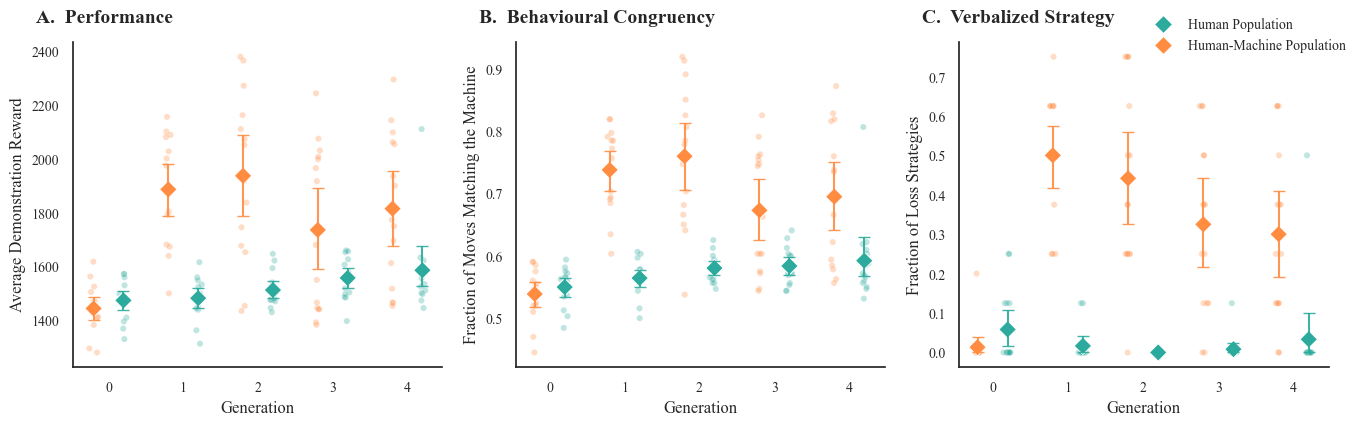

In [23]:
import seaborn as sns
import numpy as np
sns.set_theme(style='white', rc={'font.family': 'serif', 'font.serif': ['Times New Roman', 'Liberation Serif']})

metric_y_label = {
    'player_score': 'Average Demonstration Reward',
    'machine_alignment': 'Fraction of Moves Matching the Machine',
    'loss_strategy_int': 'Fraction of Loss Strategies',
}
metric_title = {
    'player_score': 'Performance',
    'machine_alignment': 'Behavioural Congruency',
    'loss_strategy_int': 'Verbalized Strategy',
}

figure_name = 'metrics_overview'

binary_metrics = ['loss_strategy_int']
continues_metrics = ['player_score', 'machine_alignment']
all_metrics = continues_metrics + binary_metrics
# all_metrics = continues_metrics

aggregations = ['mean']
legend_row_col = (0,2)
plot_machines = False
population_level_dots = True
individual_level_dots = False
error_bars = True
jitter = 0.2
y_jitter = 0.0
shift = 0.2
dot_size = 20

custom_palette = ['#2BAA9D', '#FF8C41', '#7F37B6', ]
hue_order = ['Human Population', 'Human-Machine Population']

df = player_df.copy()

df['generation_pos'] = df['generation'].astype(float)
# shift the positions of the populations slightly
df.loc[df['condition'] == 'w_ai', 'generation_pos'] -= shift
df.loc[df['condition'] == 'wo_ai', 'generation_pos'] += shift

# rename the conditions
df['condition_str'] = df['condition'].replace({'w_ai': 'Human-Machine Population', 'wo_ai': 'Human Population'})


def bootstrap_ci_yerr(x, stat_func=np.mean, n_boot=5000, ci=95, random_state=None):
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)

    # Point estimate
    theta_hat = stat_func(x)

    # Bootstrap resampling
    boot_stats = np.array([
        stat_func(rng.choice(x, size=len(x), replace=True))
        for _ in range(n_boot)
    ])

    # Percentile CI
    alpha = (100 - ci) / 2
    lower = np.percentile(boot_stats, alpha)
    upper = np.percentile(boot_stats, 100 - alpha)

    # Convert to matplotlib yerr format
    yerr_lower = theta_hat - lower
    yerr_upper = upper - theta_hat

    return np.array([yerr_lower, yerr_upper])


cols = len(all_metrics)
rows = len(aggregations)

fig = plt.figure(figsize=(cols*4.5, rows*4))
gs = gridspec.GridSpec(rows, cols)

for row, agg in enumerate(aggregations):
    for col, metric in enumerate(all_metrics):
        m_title = metric_title[metric]
        m_label = metric_y_label[metric]
        with_legend = legend_row_col[0] == row and legend_row_col[1] == col

        subplot_idx = row * cols + col
        subplot_letter = chr(65 + subplot_idx)

        ax = plt.subplot(gs[row, col])

        # aggregate the data for each generation
        generation_df = df.groupby(['replication_idx', 'generation_pos', 'condition_str', 'ai_player', 'within_generation_idx'])[metric].apply('mean').reset_index()

        ## plot human player
        human_df = generation_df[generation_df['ai_player'] == False]

        # add some jitter to the x-axis
        human_df['generation_jit_pos'] = human_df['generation_pos'] + np.random.uniform(-jitter*0.5, jitter*0.5, size=len(human_df))
        diff = human_df[metric].max() - human_df[metric].min()
        human_df[metric] = human_df[metric] + np.random.uniform(-y_jitter*0.5*diff, y_jitter*0.5*diff, size=len(human_df))

        if individual_level_dots:
            sns.scatterplot(data=human_df, x='generation_jit_pos', y=metric, hue='condition_str', hue_order=hue_order, s=dot_size, alpha=0.1, ax=ax, legend=False, palette=custom_palette)

        generation_mean_df = human_df.groupby(['generation_pos', 'condition_str'])[metric].apply(agg).reset_index()
        group_mean_df = human_df.groupby(['generation_pos', 'condition_str', 'replication_idx'])[[metric] + ["generation_jit_pos"]].apply(agg).reset_index()

        if population_level_dots:
            sns.scatterplot(data=group_mean_df, x='generation_jit_pos', y=metric, hue='condition_str', hue_order=hue_order, s=dot_size, alpha=0.3, ax=ax, legend=False, palette=custom_palette)

        yerr_df = (
            group_mean_df
            .groupby(['generation_pos', 'condition_str'])[metric]
            .apply(lambda s: bootstrap_ci_yerr(s, n_boot=5000, ci=95, random_state=0))
            .reset_index(name=f'{metric}_yerr')
        )
        generation_mean_df = generation_mean_df.merge(yerr_df, on=['generation_pos', 'condition_str'])
        sns.scatterplot(
            data=generation_mean_df, x='generation_pos', y=metric, hue='condition_str', hue_order=hue_order, s=80, alpha=1, ax=ax, marker='D', palette=custom_palette, legend=with_legend
            )

        if error_bars:
            for ic, condition in enumerate(hue_order):
                subset = generation_mean_df[
                    generation_mean_df['condition_str'] == condition
                ]
                
                ax.errorbar(
                    subset['generation_pos'],
                    subset[metric],
                    yerr=np.vstack(subset[f'{metric}_yerr'].values).T,
                    fmt='none',
                    ecolor=custom_palette[ic],
                    elinewidth=1.5,
                    capsize=4,
                    alpha=0.9
                )

        ## machine player
        if plot_machines:
            machine_df = generation_df[generation_df['ai_player'] == True]
            generation_mean_df = machine_df.groupby(['generation_pos', 'condition_str'])[metric].mean().reset_index()
            sns.scatterplot(data=generation_mean_df, x='generation_pos', y=metric, hue='condition_str', hue_order=hue_order, s=80, alpha=1, ax=ax, marker='s', palette=custom_palette, legend=False)

        ## add labels
        ax.set_xlabel('Generation', fontsize=12)
        agg_label = 'Average' if agg == 'mean' else 'Maximum'
        ax.set_ylabel(m_label, fontsize=12)


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if with_legend:
            ax.legend(frameon=False, fontsize=10, loc=(0.5, 0.95))

        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.text(-0.10, 1.10,
                f'{subplot_letter}.  {m_title}', ha='left', va='top', fontsize=14, fontweight='bold',
                transform=ax.transAxes)

png_filename = os.path.join('plots',output_folder,f'{figure_name}.png')
pdf_filename = os.path.join('plots',output_folder,f'{figure_name}.pdf')
os.makedirs(os.path.dirname(file_name), exist_ok=True)
plt.tight_layout()
fig.subplots_adjust(top=0.98, right=0.99)
plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

In [24]:
player_df.head()

session_id                      session_name  \
0   65d32e25dd6859254f5c592a     Rep 0 - Gen 0 - w_ai - 0 - AI   
12  65d32e25dd6859254f5c593a  Rep 0 - Gen 1 - w_ai - 0 - Human   
27  65d32e2add6859254f5c594a  Rep 0 - Gen 2 - w_ai - 0 - Human   
42  65d32e2edd6859254f5c595a  Rep 0 - Gen 3 - w_ai - 0 - Human   
57  65d32e32dd6859254f5c596a  Rep 0 - Gen 4 - w_ai - 0 - Human   

    replication_idx  within_generation_idx  ai_player  generation condition  \
0                 0                    0.0       True           0      w_ai   
12                0                    0.0      False           1      w_ai   
27                0                    0.0      False           2      w_ai   
42                0                    0.0      False           3      w_ai   
57                0                    0.0      False           4      w_ai   

    player_score  machine_alignment  loss_strategy                   advisor  \
0         2650.0               1.00            NaN                      None   
12        2650.0               1.00            0.0  65d32e25dd6859254f5c592b   
27        1450.0               0.75            1.0  65d32e26dd6859254f5c5940   
42        2437.5               0.95            0.0  65d32e2bdd6859254f5c594e   
57        2487.5               0.95            1.0  65d32e2edd6859254f5c595e   

   population_id  loss_strategy_int classification  
0         0 w_ai                 -1     persistent  
12        0 w_ai                  0     persistent  
27        0 w_ai                  1     persistent  
42        0 w_ai                  0     persistent  
57        0 w_ai                  1     persistent

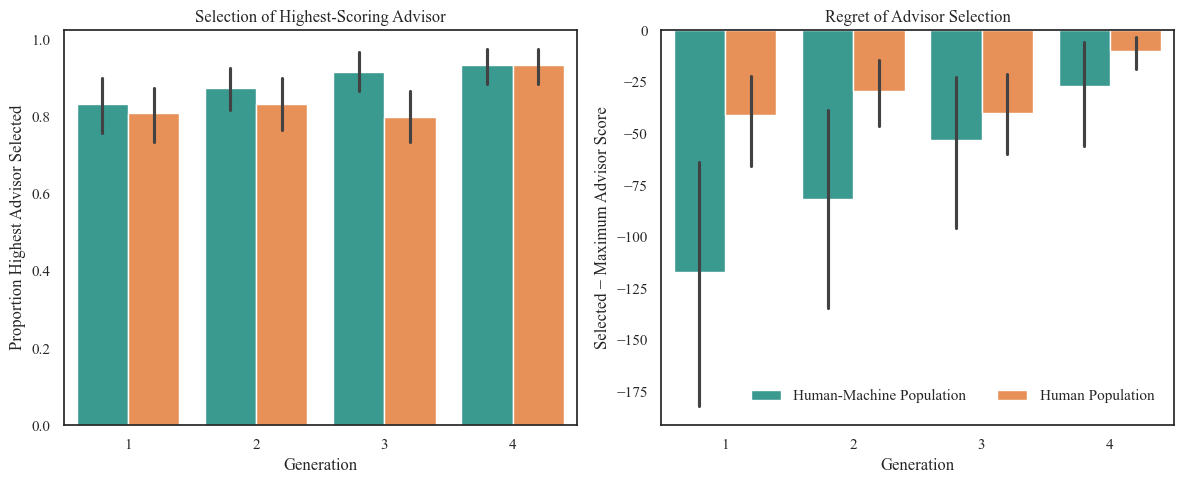

In [25]:
# Load data
player_df = pd.read_csv(
    os.path.join('../data/exp_processed', 'player.csv')
)

player_df['advisor_score_delta'] = (
    player_df['selected_advisor_score'] - player_df['max_advisor_score']
)

condition_map = {
    'w_ai': 'Human-Machine Population',
    'wo_ai': 'Human Population'
}

player_df['condition_renamed'] = (
    player_df['condition'].map(condition_map)
)

df = player_df[player_df['generation'] > 0]

custom_palette = ['#2BAA9D', '#FF8C41']

hue_order = ['Human-Machine Population', 'Human Population']

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=True
)

sns.barplot(
    ax=axes[0],
    data=df,
    x='generation',
    y='highest_advisor_selected',
    hue='condition_renamed',
    hue_order=hue_order,
    palette=custom_palette
)

axes[0].set_title('Selection of Highest-Scoring Advisor')
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Proportion Highest Advisor Selected')


sns.barplot(
    ax=axes[1],
    data=df,
    x='generation',
    y='advisor_score_delta',
    hue='condition_renamed',
    hue_order=hue_order,
    palette=custom_palette
)

axes[1].set_title('Regret of Advisor Selection')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Selected − Maximum Advisor Score')


axes[1].get_legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower right',
    ncol=2,
    bbox_to_anchor=(0.98, 0.15),
    frameon=False,
)

axes[0].get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(os.path.join('plots',output_folder,f'advisor_selection.png'), dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join('plots',output_folder,f'advisor_selection.pdf'), bbox_inches='tight', pad_inches=0.1)


In [26]:
import numpy as np

def bootstrap_mean_ci(x, n_boot=10000, seed=42, alpha=0.05):
    """
    Compute bootstrap mean and (1-alpha)% confidence interval.
    """
    x = np.asarray(x)

    rng = np.random.default_rng(seed)

    boot_samples = rng.choice(
        x,
        size=(n_boot, len(x)),
        replace=True
    )

    boot_means = boot_samples.mean(axis=1)

    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))

    return x.mean(), lower, upper

mean_sel, ci_sel_low, ci_sel_high = bootstrap_mean_ci(
    df['highest_advisor_selected']
)

mean_delta, ci_delta_low, ci_delta_high = bootstrap_mean_ci(
    df['advisor_score_delta']
)

print(
    rf"(highest advisor selected: "
    rf"$M = {mean_sel:.3f}$, "
    rf"$95\%\ \mathrm{{CI}} = [{ci_sel_low:.3f}, {ci_sel_high:.3f}]$)"
)

print(
    rf"(advisor score delta: "
    rf"$M = {mean_delta:.3f}$, "
    rf"$95\%\ \mathrm{{CI}} = [{ci_delta_low:.3f}, {ci_delta_high:.3f}]$)"
)



(highest advisor selected: $M = 0.867$, $95\%\ \mathrm{CI} = [0.845, 0.887]$)
(advisor score delta: $M = -49.871$, $95\%\ \mathrm{CI} = [-62.554, -38.562]$)


## Descriptive Statistics

We are asking: How many individuals in each condition used the optimal strategy in at least one trail?

In [27]:
# At least one trail of participant is above 2000
discovered = (player_df.groupby(['ai_player','generation', 'condition', 'session_id'])['player_score'].max() > 2000).reset_index()
discovered = discovered.rename(columns={'player_score': 'discovered'})

### Discovered by condition and generation

In [28]:
discovered.groupby(['ai_player', 'condition', 'generation', 'discovered'])['session_id'].count()

ai_player  condition  generation  discovered
False      w_ai       0           False          75
                      1           False          68
                                  True           52
                      2           False          65
                                  True           55
                      3           False          86
                                  True           34
                      4           False          82
                                  True           38
           wo_ai      0           False         120
                      1           False         120
                      2           False         120
                      3           False         119
                                  True            1
                      4           False         116
                                  True            4
True       w_ai       0           False           1
                                  True           44
Name: session_id, d

### Discovered by condition

In [29]:
discovered.groupby(['ai_player', 'condition', 'discovered'])['session_id'].count()

ai_player  condition  discovered
False      w_ai       False         376
                      True          179
           wo_ai      False         595
                      True            5
True       w_ai       False           1
                      True           44
Name: session_id, dtype: int64

### Total number of player by condition

In [30]:
discovered.groupby(['ai_player', 'condition'])['session_id'].count()

ai_player  condition
False      w_ai         555
           wo_ai        600
True       w_ai          45
Name: session_id, dtype: int64